In [150]:
# Importação de bibliotecas necessárias
import cv2
from matplotlib import pyplot as plt
import numpy as np
import argparse
import imutils
from imutils import contours


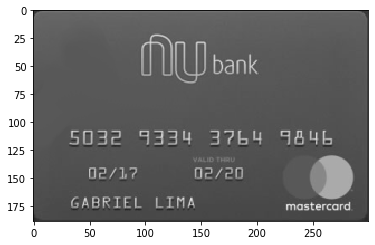

In [294]:
# Carrega a imagem do cartão para ser identificado e converte para tons de cinza
image = cv2.imread('imagens/nubank1.png')
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

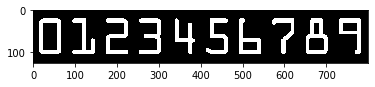

In [295]:
# Faz a leitura da imagem referência para o OCR dos números, converte ela para escala de Cinza
ref = cv2.imread('ocr_a_reference.png')
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ref = cv2.threshold(ref, 10, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))

In [296]:
#Cria dicionário para ligar o tipo do cartão ao primeiro dígito baseado na 
PrimeiroNumero = {"3": "American Express", "4": "Visa","5": "MasterCard","6": "Discover Card","7": "Fake"}

In [297]:
# find contours in the OCR-A image (i.e,. the outlines of the digits)
# sort them from left to right, and initialize a dictionary to map
# digit name to the ROI
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
refCnts = imutils.grab_contours(refCnts)
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
digits = {}

In [298]:
# loop over the OCR-A reference contours
for (i, c) in enumerate(refCnts):
    # Compute the bounding box for the digit, 
    # extract it, and resize it to a fixed size. 
    (x, y, w, h) = cv2.boundingRect(c)
    roi = ref[y:y + h, x:x + w]
    roi = cv2.resize(roi, (57, 88))

    # update the digits dictionary, mapping the digit name to the ROI
    digits[i] = roi

In [299]:
# Inicia um retângulo na horizontal
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

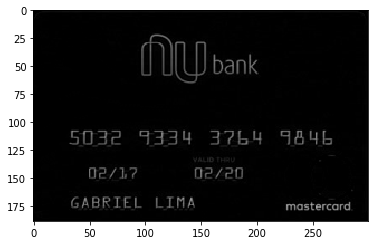

In [300]:
#aplica filtro tophat, escurecendo o fundo
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)
plt.imshow(cv2.cvtColor(tophat, cv2.COLOR_BGR2RGB))

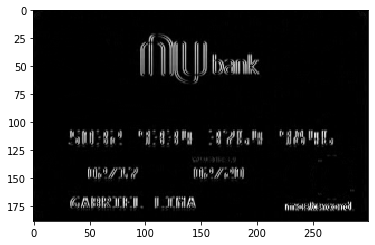

In [301]:
# Faz a localização de gradientes e bordas utilizando função de Sobel
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")
plt.imshow(cv2.cvtColor(gradX, cv2.COLOR_BGR2RGB))

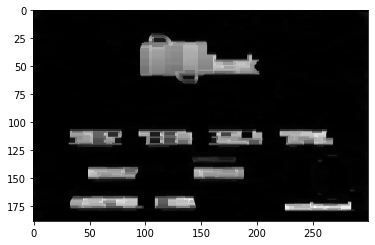

In [302]:
# fecha os retângulos nos agrupamentos de números
# Aplica o método de Otsu para binarizar a imagem
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(cv2.cvtColor(gradX, cv2.COLOR_BGR2RGB))


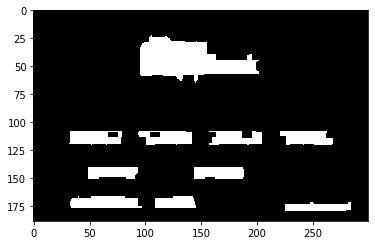

In [303]:
# Aplica novamente a binariazação para ajudar a identificação do  espaçamento entre os grupos de números
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

In [304]:
# encontra os contornos e inicializa a lista da localização dos digitos.
# list of digit locations
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
locs = []
print (cnts)

[array([[[248, 172]],

       [[248, 173]],

       [[247, 174]],

       [[226, 174]],

       [[226, 179]],

       [[279, 179]],

       [[280, 178]],

       [[284, 178]],

       [[284, 172]],

       [[282, 172]],

       [[282, 173]],

       [[281, 174]],

       [[252, 174]],

       [[250, 172]]], dtype=int32), array([[[125, 167]],

       [[124, 168]],

       [[109, 168]],

       [[109, 176]],

       [[145, 176]],

       [[145, 175]],

       [[144, 174]],

       [[144, 171]],

       [[143, 170]],

       [[143, 168]],

       [[142, 167]]], dtype=int32), array([[[ 40, 167]],

       [[ 39, 168]],

       [[ 35, 168]],

       [[ 34, 169]],

       [[ 34, 170]],

       [[ 33, 171]],

       [[ 33, 175]],

       [[ 34, 176]],

       [[ 97, 176]],

       [[ 94, 176]],

       [[ 93, 175]],

       [[ 93, 168]],

       [[ 82, 168]],

       [[ 81, 167]],

       [[ 52, 167]],

       [[ 51, 168]],

       [[ 41, 168]]], dtype=int32), array([[[144, 141]],

       [[14

In [305]:
# cria um loop com o array de contornos.
for (i, c) in enumerate(cnts):
    # Calcula a caixa delimitadora dos contornos criando uma caixa mantendo o aspecto
    
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)

    # a maioria dos cartões usa 4 grupos de 4 dígitos mantendo o aspecto
    if ar > 2.5 and ar < 4.0:
        # Busca altura largura e altura para os retângulos
        # and height
        if (w > 40 and w < 55) and (h > 10 and h < 20):
            # faz o append das posições largura e altura dos retângulos
            locs.append((x, y, w, h))

In [306]:
# classifica os digitos da esquerda para a direita para ordenar
locs = sorted(locs, key=lambda x:x[0])
output = []

In [307]:
# FAz um loop para verificação dentro da área de cada retângulo, para fazer o OCR
for (i, (gX, gY, gW, gH)) in enumerate(locs):
    # inicializa uma variável
    groupOutput = []

    # Seleciona na imagem em tons de cinza as cooredenadas de cada retângulo
    # após isso aplica a binarização por otsu novamente
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    group = cv2.threshold(group, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # detecta os contornos individuais dos dígitos do grupo,
    # then sort the digit contours from left to right
    digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digitCnts = imutils.grab_contours(digitCnts)
    digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]
    
    # loop over the digit contours
    for c in digitCnts:
        # compute the bounding box of the individual digit, extract
        # the digit, and resize it to have the same fixed size as
        # the reference OCR-A images
        (x, y, w, h) = cv2.boundingRect(c)
        roi = group[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))

        # initialize a list of template matching scores
        scores = []

        # loop over the reference digit name and digit ROI
        for (digit, digitROI) in digits.items():
            # apply correlation-based template matching, take the
            # score, and update the scores list
            result = cv2.matchTemplate(roi, digitROI, cv2.TM_CCOEFF)
            
            (_, score, _, _) = cv2.minMaxLoc(result)
            
            scores.append(score)

        # The classification for the digit ROI will be the reference
        # digit name with the *largest* template matching score
        groupOutput.append(str(np.argmax(scores)))
        
    # draw the digit classifications around the group
    cv2.rectangle(image, (gX - 5, gY - 5),
        (gX + gW + 5, gY + gH + 5), (0, 0, 255), 2)
    cv2.putText(image, "".join(groupOutput), (gX, gY - 15),
        cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)

    # update the output digits list
    output.extend(groupOutput)
    
print("Credit Card #: {}".format("".join(output)))

Credit Card #: 5032933437649846


Bandeira: MasterCard
Credit Card #: 5032933437649846


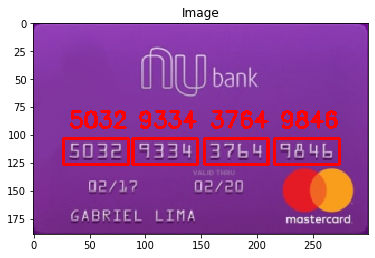

In [308]:
# display the output credit card information to the screen
print("Bandeira: {}".format(PrimeiroNumero[output[0]]))
print("Credit Card #: {}".format("".join(output)))
# cv2.imshow("Image", image)
# cv2.waitKey(0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image'); plt.show()

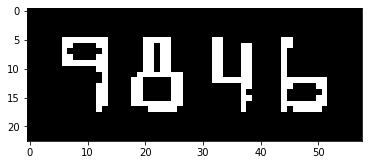

In [309]:
plt.imshow(cv2.cvtColor(group, cv2.COLOR_BGR2RGB))